# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv
import os, sys


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model

%cd /home/jovyan/ASMSA/mydev


repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import plot_latent_space
from src.asmsa_callbacks import callbacks
from src.ae import asmsa_ae
from src.asmsa_features import process_trajectory
from src.asmsa_split import asmsa_datasets

nn_model = 'ae'
latent_dim = 2

2025-08-12 13:07:16.509888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-12 13:07:16.522935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-12 13:07:16.526817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 13:07:16.536380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 13:07:17.150878: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)


<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x71fe3410b0d0>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
feat = process_trajectory(tr, conf)


## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all, info = asmsa_datasets(feat['features_normalized'], train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1754996841.067372  283162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754996841.085375  283162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754996841.085543  283162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754996841.086291  283162 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Split Statistics:
  Total samples: 50001
  Train: 35000 samples (70.0%), 546 batches
  Val:   7500 samples (15.0%), 118 batches
  Test:  7501 samples (15.0%), 118 batches
  Batch size: 64
  Features shape: (50001, 558)
  Seed: 42

Validazione splits:


2025-08-12 13:07:22.406396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-12 13:07:22.556735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  Train batch shape: (64, 558)
  Val batch shape: (64, 558)
  Test batch shape: (64, 558)
  ✓ Tutti gli split sono validi per autoencoder


2025-08-12 13:07:22.754533: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# AE

In [6]:
'''
Batch Norm, nel caso, va prima della layer activation)
'''

'\nBatch Norm, nel caso, va prima della layer activation)\n'

In [7]:
autoencoder, encoder, decoder = asmsa_ae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim)

autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 558)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        82,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 558)            │        83,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,256 (649.44 KB)

 Trainable params: 165,360 (645.94 KB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
def hybrid_loss(y_true, y_pred):
    # Separa coordinate e angoli
    coords_true = y_true[:, :feat['n_coord_features']]
    coords_pred = y_pred[:, :feat['n_coord_features']] 
    angles_true = y_true[:, feat['n_coord_features']:]
    angles_pred = y_pred[:, feat['n_coord_features']:]
    
    # MSE+MAE per coordinate
    coord_mse = tf.reduce_mean(tf.square(coords_true - coords_pred))
    coord_mae = tf.reduce_mean(tf.abs(coords_true - coords_pred))
    coord_loss = 0.8 * coord_mse + 0.2 * coord_mae
    
    # MSE+MAE per angoli (più MAE per robustezza ai salti angolari)
    angle_mse = tf.reduce_mean(tf.square(angles_true - angles_pred))
    angle_mae = tf.reduce_mean(tf.abs(angles_true - angles_pred))  
    angle_loss = 0.6 * angle_mse + 0.4 * angle_mae
    
    return coord_loss + 2.0 * angle_loss  # Peso maggiore agli angoli

In [9]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cb = callbacks(log_dir, latent_dim, monitor="val_loss", model=nn_model)  

learning_rate = 1e-4
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-5, 
    beta_1=0.9,
    beta_2=0.999
)

# Assuming asmsa_ae function exists
ae, encoder, decoder = asmsa_ae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim
)

mse_fn = tf.keras.losses.MeanSquaredError()
mae_fn = tf.keras.losses.MeanAbsoluteError()

# Definisco la loss ricostruzione pesata
def recon_loss(y_true, y_pred):
    mse = mse_fn(y_true, y_pred)
    mae = mae_fn(y_true, y_pred)
    return 0.8 * mse + 0.2 * mae

# Compilo l'autoencoder con la loss personalizzata
ae.compile(optimizer=optimizer,
           loss=hybrid_loss)


tensorboard --logdir logs/autoencoder --host localhost --port 6006

In [10]:
ae.fit(ds_train,epochs=200,validation_data=ds_val,callbacks=cb)

Epoch 1/200


I0000 00:00:1754996846.956070  283218 service.cc:146] XLA service 0x71fc8001c4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754996846.956090  283218 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-12 13:07:27.033821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-12 13:07:27.379577: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 53/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4308

I0000 00:00:1754996850.627242  283218 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


543/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1657
Epoch 1: val_loss improved from inf to 0.78110, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.1645 - val_loss: 0.7811 - learning_rate: 1.0000e-04
Epoch 2/200
530/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8185
Epoch 2: val_loss improved from 0.78110 to 0.76310, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8181 - val_loss: 0.7631 - learning_rate: 1.0000e-04
Epoch 3/200
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7909
Epoch 3: val_loss improved from 0.76310 to 0.75711, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7909 - val_loss: 0.7571 - learning_rate: 1.0000e-04
Epoch 4/200
525/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7788
Epoch 4: val_loss improved from 0.75711 to 0.75298, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7787 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 5/200


In [11]:
src = f"ae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

# Decode and visualize

In [12]:
path = f"/home/tedeschg/prj/ASMSA/mydev/models/ae_{latent_dim}d.keras"

autoencoder = load_model(
    path,
    custom_objects={"recon_loss2": recon_loss}
)

encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")


TypeError: Could not locate function 'hybrid_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'hybrid_loss', 'registered_name': 'function'}

In [13]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
test = encoder.predict(sample_x_batch)

test

2025-08-12 13:12:05.436710: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


array([[ 0.9691193, -1.7380992]], dtype=float32)

 41/782 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step


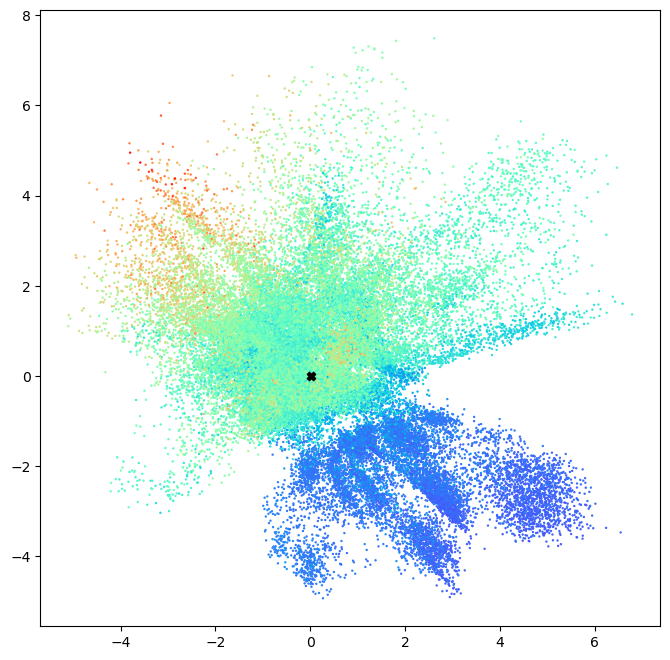

In [19]:
target = np.array([0, 0]).reshape(1, latent_dim)
bb_indices = traj.topology.select('backbone')
ca_indices = traj.topology.select('name CA')
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, target, bb_indices, model=nn_model, exact=True)

In [20]:


rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [21]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [22]:
s = decoder.predict(sample)

coords_size = feat['coords'].shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = feat['scaler_coords'].inverse_transform(s_coords)
angles_orig = feat['scaler_angles'].inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)

new_traj.save_pdb("./models/ae_reconstructed.pdb")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [23]:
view = nv.show_file('./models/ae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()

In [24]:
mse = np.mean((s[0] - sample_x.numpy())**2)
print("MSE ricostruzione:", mse)

MSE ricostruzione: 0.117635444


/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152

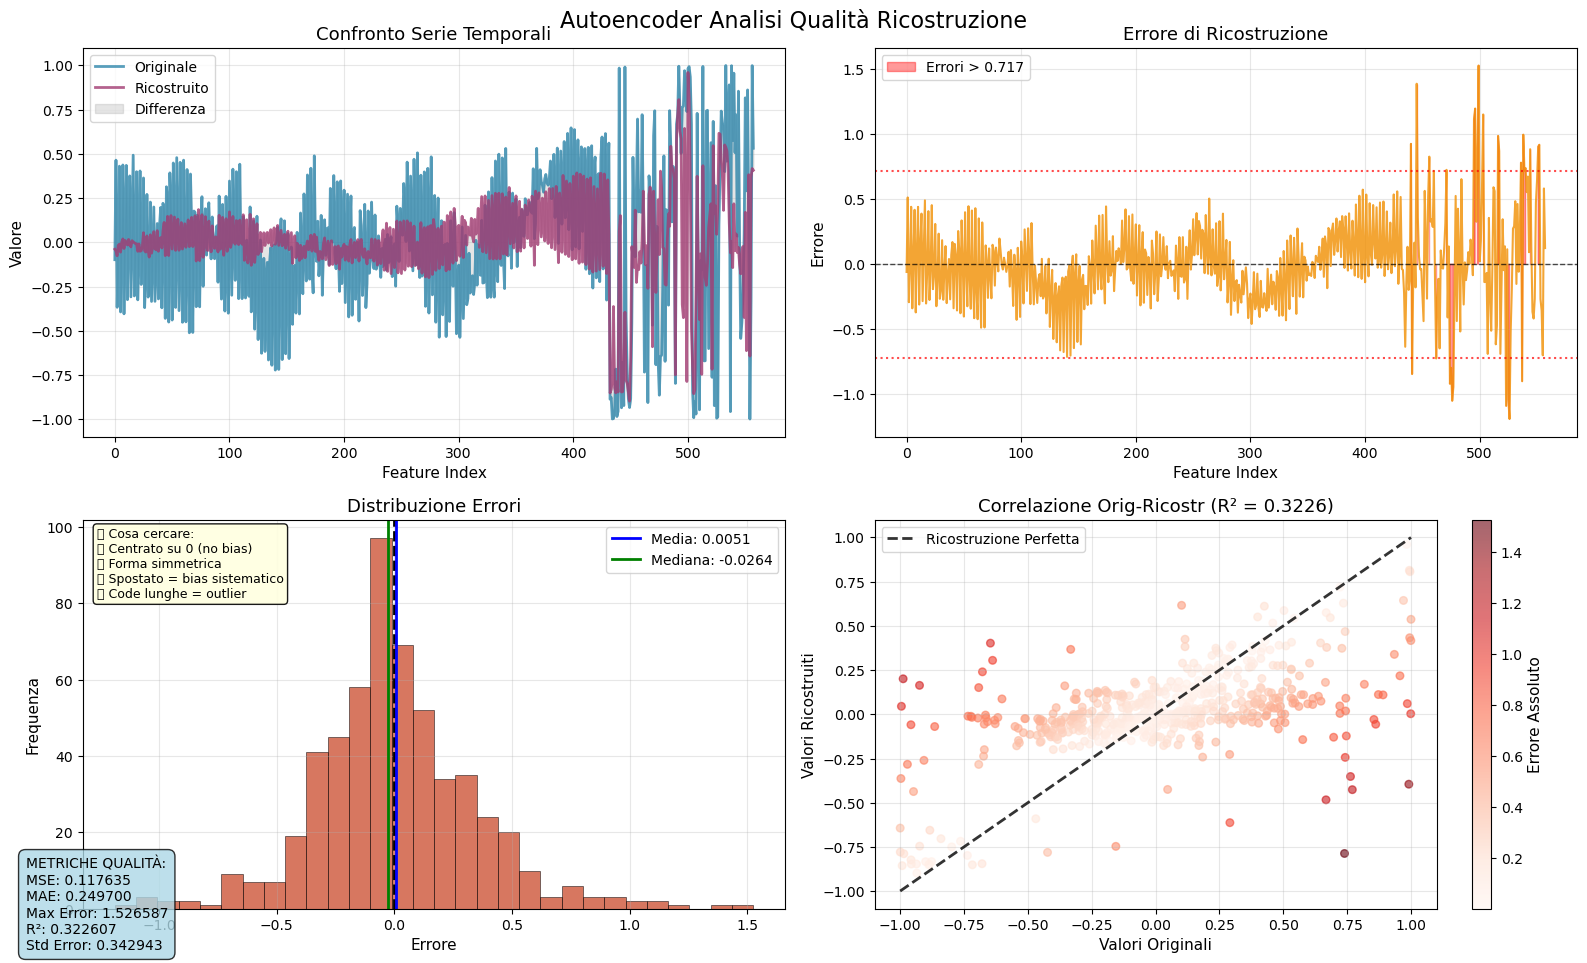

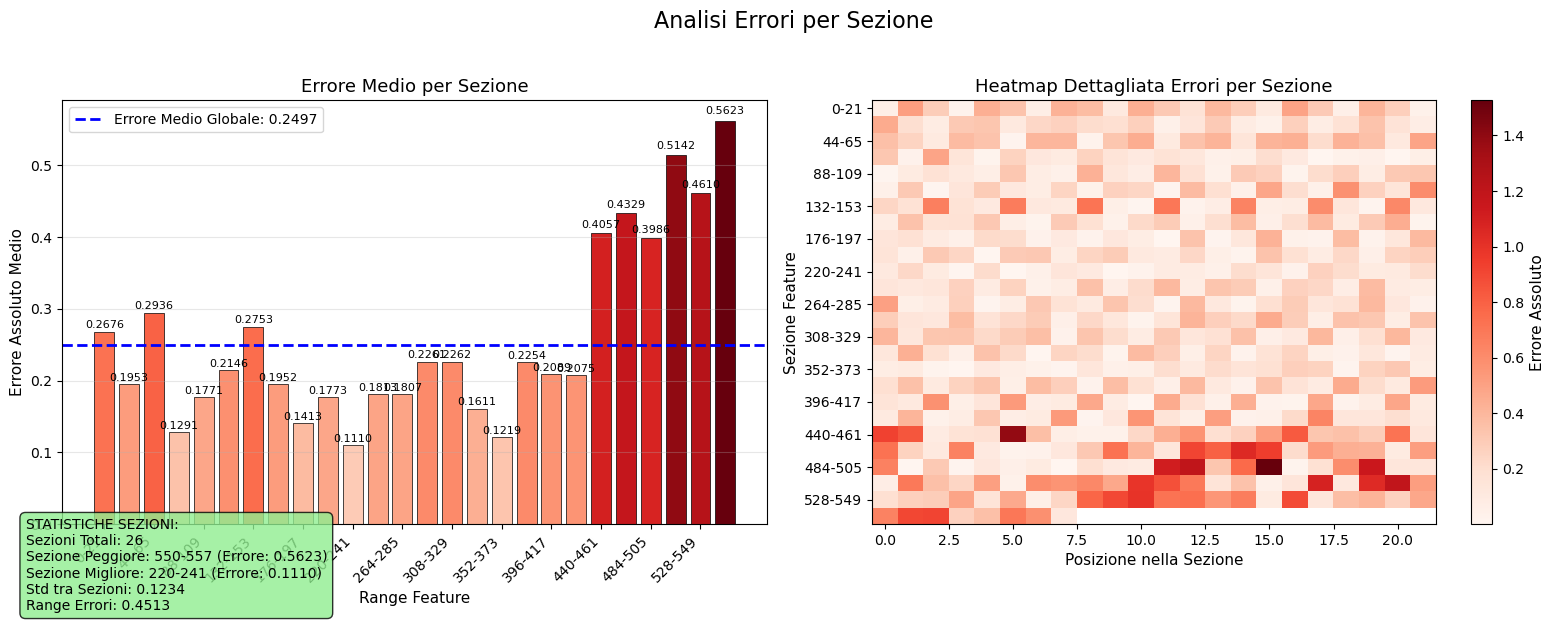


=== METRICHE RICOSTRUZIONE ===


In [25]:
from src.asmsa_analysis import analyze_reconstruction, plot_section_errors
import matplotlib.pyplot as plt
# Utilizzo con i tuoi dati
# Assumendo che sample_x e s[0] siano definiti
orig = sample_x.numpy() 
recon = s[0]

# Analisi completa
fig, metrics = analyze_reconstruction(orig, recon, title_prefix="Autoencoder ")

# Solo errori per sezione
fig_sections, section_stats = plot_section_errors(orig, recon, n_sections=25, 
                                                   title="Analisi Errori per Sezione")

plt.show()

# Stampa metriche
print("\n=== METRICHE RICOSTRUZIONE ===")
for metric, value in metrics.items():
    (f"{metric.upper()}: {value:.6f}")